In [1]:
import os

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

## 1) 데이터 준비와 확인

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터 로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴



In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
word_to_index['<PAD>']=9998
len(word_to_index)

9998

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [9]:
vocab_size = 9998  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

### LSTM

In [10]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.LSTM(32),   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
])

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 32)            319936    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 328,529
Trainable params: 328,529
Non-trainable params: 0
_________________________________________________________________


### GMP

In [11]:
model_GMP = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.GlobalMaxPooling1D(), #global max pooling 사용
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_GMP.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 32)            319936    
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 321,025
Trainable params: 321,025
Non-trainable params: 0
_________________________________________________________________


### GRU

In [12]:
model_GRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.GRU(32), # Gated Recurrent Unit 사용
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])  

model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 32)            319936    
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 326,545
Trainable params: 326,545
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

In [13]:
epochs=10

### LSTM

In [14]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history_LSTM = model_LSTM.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=0)

In [15]:
results_LSTM = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results_LSTM)

1537/1537 - 3s - loss: 0.3966 - accuracy: 0.8505
[0.3966226577758789, 0.8504993915557861]


### GMP

In [16]:
model_GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
             
history_GMP = model_GMP.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=0)

In [17]:
results_GMP = model_GMP.evaluate(X_test,  y_test, verbose=2)

print(results_GMP) 

1537/1537 - 2s - loss: 0.3892 - accuracy: 0.8413
[0.3891962170600891, 0.8412637114524841]


### GRU

In [18]:
model_GRU.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history_GRU = model_GRU.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=0)

In [19]:
results_GRU = model_GRU.evaluate(X_test,  y_test, verbose=2)

print(results_GRU)

1537/1537 - 3s - loss: 0.3846 - accuracy: 0.8515
[0.38457635045051575, 0.851455569267273]


## 6) Loss, Accuracy 그래프 시각화

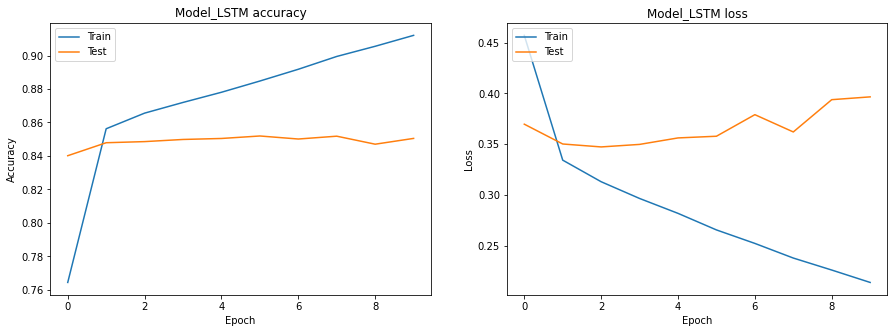

In [20]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)  
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('Model_LSTM accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)  
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Model_LSTM loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

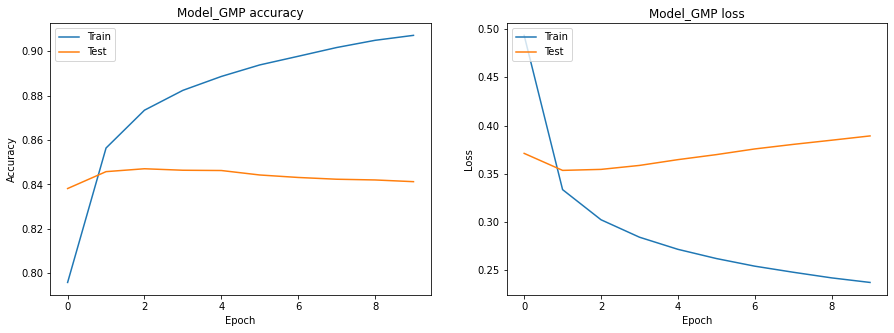

In [21]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)  
plt.plot(history_GMP.history['accuracy'])
plt.plot(history_GMP.history['val_accuracy'])
plt.title('Model_GMP accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)  
plt.plot(history_GMP.history['loss'])
plt.plot(history_GMP.history['val_loss'])
plt.title('Model_GMP loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

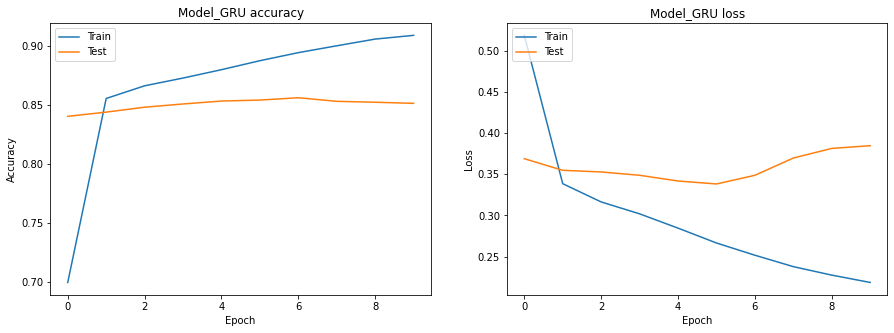

In [22]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)  
plt.plot(history_GRU.history['accuracy'])
plt.plot(history_GRU.history['val_accuracy'])
plt.title('Model_GRU accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)  
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Model_GRU loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## 7) 학습된 Embedding 레이어 분석

임베딩 레이어는 단어를 의미론적 기하공간에 매핑할 수 있도록 벡터화 시켜줍니다.<br>
keras [공식문서](https://keras.io/api/layers/core_layers/embedding/)에서 `Embedding layer`
에 대하여 자세히 살펴볼 수 있습니다.
```py
tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length)
```
- vocab_size: 단어 집합의 크기. 즉, 총 단어의 개수
- word_vector_dim: 임베딩 벡터의 출력 차원. 결과로서 나오는 임베딩 벡터의 크기
- input_length: 입력 시퀀스의 길이

keras의 Embedding 레이어는 처음에 무작위로 초기화된 상태에서 정수로 오는 word를 정해진 크기의 벡터로 바꿔서 다음 레이어로 넘기고, <br>
학습단계에서는 역전파되는 기울기를 바탕으로 해당 word의 임베딩 값을 업데이트합니다. 따라서 단어 주변 문맥을 반영하지 않습니다.<br>
이를 개선한 문맥 기반의 임베딩 기법인 Word2Vec을 활용하여 성능을 개선 할 수 있습니다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.

In [23]:
# !pip install --upgrade gensim==3.8.3

import gensim

word2vec_path = './data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [24]:
word2vec.similar_by_word("감동")

[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [26]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 


### LSTM

In [27]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.LSTM(32),   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
])

model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,030,097
Trainable params: 2,030,097
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history_LSTM = model_LSTM.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=0)

In [29]:
results_LSTM = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results_LSTM)

1537/1537 - 3s - loss: 0.4491 - accuracy: 0.8499
[0.4490542709827423, 0.8499298095703125]


### GMP

In [30]:
model_GMP = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.GlobalMaxPooling1D(), #global max pooling 사용
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_GMP.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history_GMP = model_GMP.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=0)

In [32]:
results_GMP = model_GMP.evaluate(X_test,  y_test, verbose=2)

print(results_LSTM)

1537/1537 - 2s - loss: 0.5973 - accuracy: 0.8385
[0.4490542709827423, 0.8499298095703125]


### GRU

In [33]:
model_GRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.GRU(32), # Gated Recurrent Unit 사용
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])  

model_GRU.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                22464     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,022,737
Trainable params: 2,022,737
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_GRU.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history_GRU = model_GRU.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=0)

In [35]:
results_GRU = model_GRU.evaluate(X_test,  y_test, verbose=2)

print(results_GRU)

1537/1537 - 3s - loss: 0.4951 - accuracy: 0.8501
[0.49510958790779114, 0.8500722050666809]


- 대부분의 경우에서 Word2vec 임베딩을 사용했을 경우 성능이 소폭 향상되는 모습을 확인할 수 있습니다.

 ## 회고
한글 문장 데이터도 영어와 마찬가지로 여러가지 전처리를 통해 모델에 사용할 수 있다는 것을 알게 되었습니다. 또한 rnn신경망에 대하여 알아보았고 word2vec 임베딩을 통하여 성능향상을 해볼 수 있었습니다.